In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio

from desc.equilibrium import EquilibriaFamily, Equilibrium
from desc.plotting import plot_surfaces
from desc.objectives import MagneticWell
from desc.grid import LinearGrid
from desc.transform import Transform
from desc.compute import compute_geometry, data_index

DESC version 0.4.13+569.gf25e5b1.dirty, using JAX backend, jax version=0.2.25, jaxlib version=0.1.76, dtype=float64
Using device: CPU, with 11.24 GB available memory


In [2]:
class MagneticWellVisual:
    """
    to print and plot more (less) quantities, add (remove) them to the dict
    returned from MagneticWell.compute() and self.st and data_variables
    everything else is automatic
    """

    X = 0  # index of coordinate tuple (x_pts, y_pts)
    Y = 1  # index of coordinate tuple (x_pts, y_pts)
    data_variables = ("p_r",)  # list of keys returned in data dict

    def __init__(
        self,
        name,
        eq=None,
        has_stellopt_data=False,
        use_stellopt_rho=False,
        rho=np.linspace(1 / 32, 1, 32),  # number of points to plot, reduce for speed
    ):
        """
        make a MagneticWellVisual from either the provided equilibrium
        or the final equilibrium loaded from the output.h5 solution
        if the latter option is chose, name should match prefix of
        of the examples/DESC/<name>_output.h5 file
        """
        self.name = name
        if eq is None:
            # collect final equilibrium
            eq = EquilibriaFamily.load(
                load_from="examples/DESC/" + name + "_output.h5"
            )[-1]
        self.eq = eq
        self.st = dict()  # values are tuples of (x[i], y[i]) of plotable data

        if has_stellopt_data:
            # pull stellopt data from matlab .mat file
            mat = sio.loadmat("magwell-data/" + name + "_magwell.mat")
            self.st["STELLOPT Magnetic Well"] = mat["rho"], mat["magwell"]
            if use_stellopt_rho:
                rho = mat["rho"]

        # y points are cached when compute_plot() is called
        self.rho = rho
        l = len(rho)
        self.st["DESC Magnetic Well"] = rho, np.empty(l)
        self.st["V surface integral"] = rho, np.empty(l)
        self.st["V surface integral with weights"] = rho, np.empty(l)
        self.st["dv_drho"] = rho, np.empty(l)
        self.st["dv_drho with weights"] = rho, np.empty(l)
        self.st["pressure_average"] = rho, np.empty(l)
        self.st["Bsquare_average"] = rho, np.empty(l)
        self.st["p_r"] = rho, np.empty(l)
        self.st["sum( 1 * dt * dz)"] = rho, np.empty(l)
        self.st["sum(dr * dt * dz)"] = rho, np.empty(l)

    def print_values(self, grid=None, print_data_V=True, print_stellopt=False):
        """
        prints what is returned by MagneticWell.compute()
        the default grid=None uses the rho=1 flux surface
        """
        print(self.name)
        print(self.eq)
        mw = MagneticWell(eq=self.eq, grid=grid)
        # helpful to see the grid
        # although this grid is from a rho=1 MagneticWell, grid.spacing
        # is the same for any rho=constant surfaces of a given equilibrium
        print("grid.spacing(dr,dt,dz)", mw.grid.spacing[0])
        m = mw.compute(
            self.eq.R_lmn,
            self.eq.Z_lmn,
            self.eq.L_lmn,
            self.eq.p_l,
            self.eq.i_l,
            self.eq.Psi,
        )
        for key, val in m.items():
            if key == "data":
                for var in MagneticWellVisual.data_variables:
                    print('{0}["{1}"] {2}'.format(key, var, val[var]))
            else:
                print(key, val)
        if print_data_V:
            self.print_data_V()
        if print_stellopt:
            self.print_stellopt()
        print()

    def print_data_V(self):
        """
        print the volume of the stellerator device as computed by data["V"]
        should match V surface integral when the default grid with rho = 1
        is used to construct the MagneticWell() object
        """
        # need grid with array for rho to compute accurate data["V"]
        # different than grid used in MagneticWell() construction
        grid = LinearGrid(
            M=2 * self.eq.M_grid + 1,
            N=2 * self.eq.N_grid + 1,
            NFP=self.eq.NFP,
            sym=self.eq.sym,
            rho=np.linspace(1 / 128, 1, 128),
        )
        R_transform = Transform(
            grid, self.eq.R_basis, derivs=data_index["sqrt(g)"]["R_derivs"], build=True
        )
        Z_transform = Transform(
            grid, self.eq.Z_basis, derivs=data_index["sqrt(g)"]["R_derivs"], build=True
        )
        data = compute_geometry(self.eq.R_lmn, self.eq.Z_lmn, R_transform, Z_transform)
        print('data["V"]', data["V"])

    def print_stellopt(self):
        """print the STELLOPT magnetic well data"""
        if (s := "STELLOPT Magnetic Well") in self.st:
            print(s)
            rhos, wells = self.st[s]
            for rho, well in zip(rhos, wells):
                print(rho, well)

    def compute_plot(self):
        """
        compute and cache MagneticWell.compute() values
        for the given array of rho=constant surfaces
        """
        for i in range(len(self.rho)):
            mw = MagneticWell(
                eq=self.eq,
                grid=LinearGrid(
                    L=1,
                    M=2 * self.eq.M_grid + 10,  # +1 not enough for torus volume
                    N=2 * self.eq.N_grid + 10,
                    NFP=self.eq.NFP,  # will work if using grid.weights
                    sym=False,  # required for correctness of volume
                    rho=self.rho[i],
                ),
            )
            m = mw.compute(
                self.eq.R_lmn,
                self.eq.Z_lmn,
                self.eq.L_lmn,
                self.eq.p_l,
                self.eq.i_l,
                self.eq.Psi,
            )
            assert m["check_derivs_B_r"] and m["check_derivs_p_r"]
            # cache computed quantity in the y coordinate array
            for key, val in m.items():
                if key == "data":
                    for var in MagneticWellVisual.data_variables:
                        # for arrays like "p_r" just get first element
                        y = val[var][0] if val[var].ndim > 0 else val[var]
                        self.st[var][MagneticWellVisual.Y][i] = y
                elif key in self.st:
                    self.st[key][MagneticWellVisual.Y][i] = val

            self.st["W * p_r / dv_drho with weights"] = (
                self.rho,
                self.st["DESC Magnetic Well"][MagneticWellVisual.Y]
                * self.st["p_r"][MagneticWellVisual.Y]
                / self.st["dv_drho with weights"][MagneticWellVisual.Y],
            )

    def plot(self, width=6, height=6, scatter=True):
        """
        plot all quantities cached from compute_plot()
        and STELLOPT data if it exists
        """
        fig, ax = plt.subplots(ncols=len(self.st))
        fig.set_size_inches(len(self.st) * width, height)

        i = 0
        for key, val in self.st.items():
            x, y = val
            if scatter:
                ax[i].scatter(x, y)
            ax[i].plot(x, y)
            ax[i].set(
                xlabel="rho",
                ylabel=key,
                title=self.name,
                yscale=("symlog" if np.any(y < 0) else "log")
                if "Magnetic Well" in key
                else "linear",
            )
            i += 1

In [3]:
torus = MagneticWellVisual("torus", Equilibrium())
dshape = MagneticWellVisual(
    "DSHAPE", has_stellopt_data=True, use_stellopt_rho=True
)
heliotron = MagneticWellVisual(
    "HELIOTRON", has_stellopt_data=True, use_stellopt_rho=True
)
mobius = MagneticWellVisual("MOBIUS", has_stellopt_data=False)
axisym = MagneticWellVisual("AXISYM", has_stellopt_data=False)

In [4]:
# just to make sure equilibrium were solved correctly on my computer
# plot_surfaces(torus.eq)
# plot_surfaces(dshape.eq)
# plot_surfaces(heliotron.eq)
# plot_surfaces(mobius.eq)
# plot_surfaces(axisym.eq)

In [5]:
torus.print_values()
dshape.print_values()
heliotron.print_values()
mobius.print_values()
axisym.print_values()

torus
Equilibrium at 0x7fc4d406b550 (L=1, M=1, N=0, NFP=1, sym=False, spectral_indexing=ansi)
grid.spacing(dr,dt,dz) [1.         0.52359878 0.62831853]
Bsquare_average 0.1013211836423378
DESC Magnetic Well [5.20769917e-17]
V surface integral 197.39208802178715
V surface integral with weights 197.39208802178715
check_derivs_B_r True
check_derivs_p_r True
data["p_r"] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
dv_drho 394.78417604357423
dv_drho with weights 394.78417604357423
pressure_average 2.673107364942938e-20
sum( 1 * dt * dz) 39.47841760435743
sum(dr * dt * dz) 39.47841760435743
data["V"] 198.93421370945734

DSHAPE
Equilibrium at 0x7fc4b46720d0 (L=26, M=13, N=0, NFP

 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
dv_drho 155.32552999107918
dv_drho with weights 155.32552999107918
pressure_average -0.00010766972080574617
sum( 1 * dt * dz) 39.47841760435743
sum(dr * dt * dz) 39.47841760435743
data["V"] 98.70161084798525



In [6]:
torus.compute_plot()
dshape.compute_plot()
heliotron.compute_plot()
mobius.compute_plot()
axisym.compute_plot()

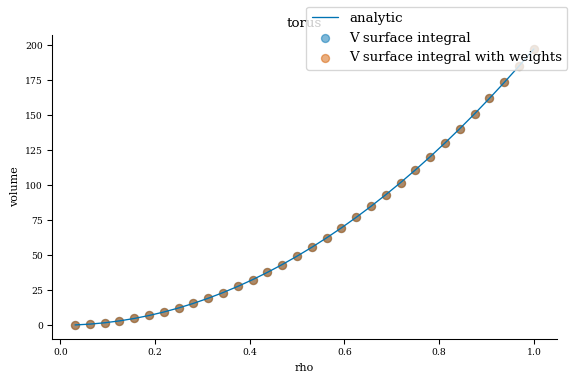

In [7]:
# compare volume computation to known analytic case of torus
fig, ax = plt.subplots()
s = "V surface integral"
rho, volume = torus.st[s]
rho2, volume2 = torus.st[s + " with weights"]
ax.scatter(rho, volume, label=s, alpha=0.5)
ax.scatter(rho2, volume2, label=s + " with weights", alpha=0.5)
ax.plot(rho, 20 * (np.pi * rho) ** 2, label="analytic")
ax.set(xlabel="rho", ylabel="volume", title=torus.name)
fig.legend()

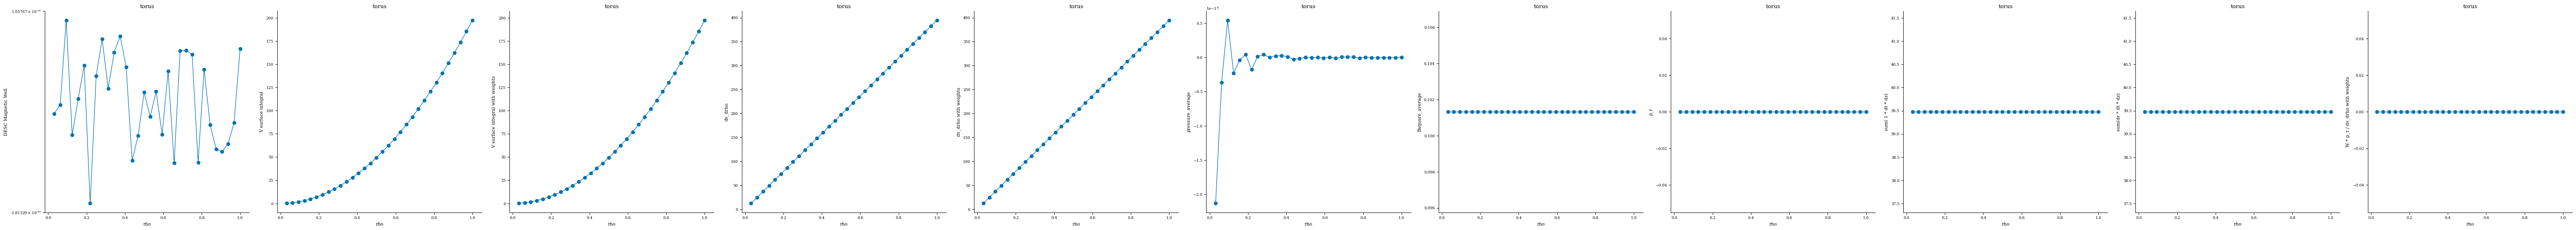

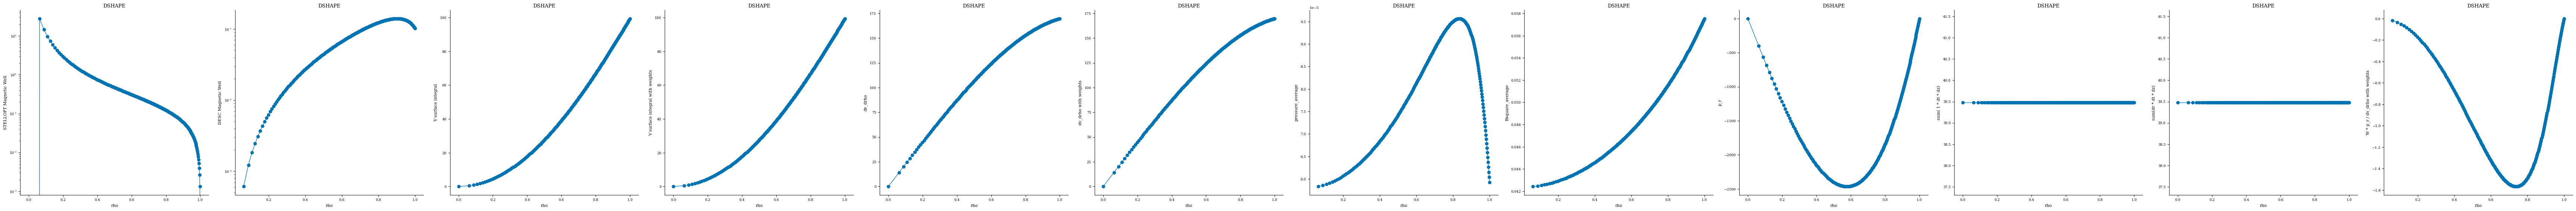

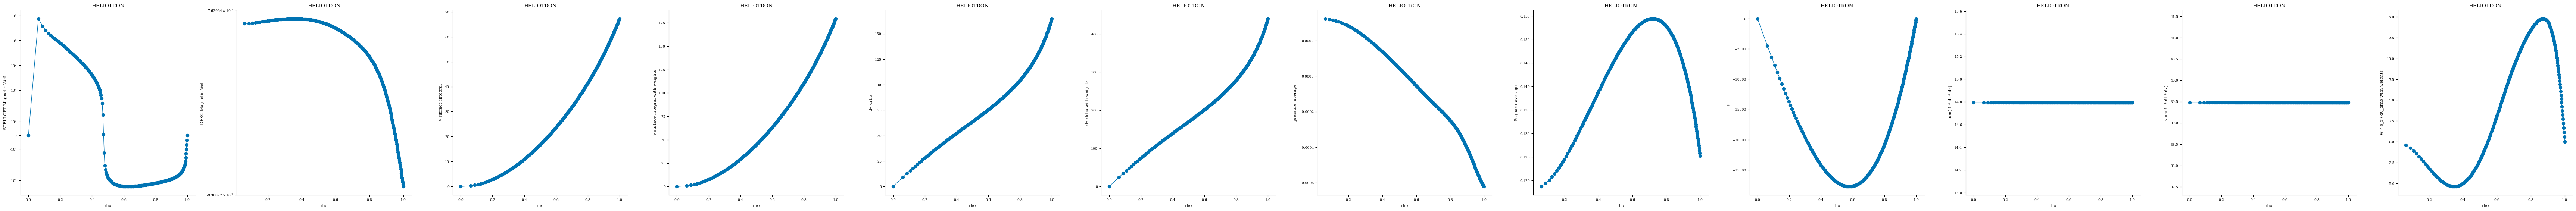

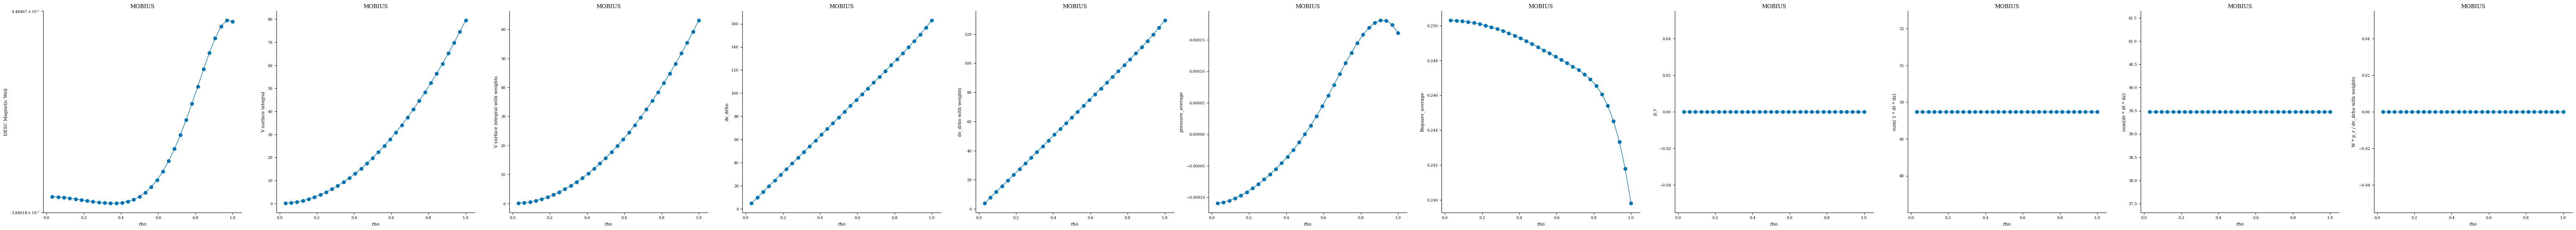

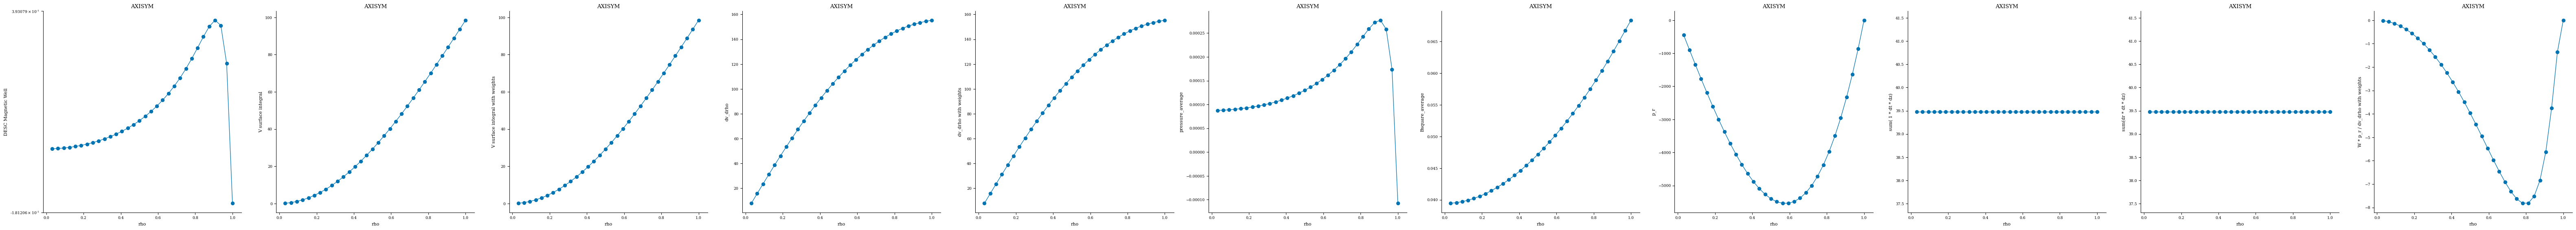

In [8]:
torus.plot()
dshape.plot()
heliotron.plot()
mobius.plot()
axisym.plot()